# A maximally simple solution to CT / CTA detection!

In [1]:
import sys
sys.version

'3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 21:41:56) \n[GCC 7.3.0]'

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
pd.set_option('precision', 2)
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom
import os
from glob import glob

import keras
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from keras.models import Sequential, model_from_json

from skimage.transform import downscale_local_mean
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Loading DICOM from the SHAIP environment

In [3]:
DICOM_PATH = 'data/dicom_dir/'
SMILY = u'\U0001F603'

In [4]:
class Cohort(object):
    """ 
    Manages a SHAIP-like cohort of datasets, finding what datasets are available, reading data and GT.
    Deals only with the raw input data - no normalization happens here.  
    Accessors generally present lazy evaluation semantics.
    """
    def __init__(self):
        """ The constructor scans the data path to find what data is present and
        setup a list and dictionary of dataset ids and paths.  It does not *read*
        the data"""
        self.dicom_path = 'data/dicom_dir/'
        self.filepaths = glob(DICOM_PATH + '*.dcm')
        self.ids = [os.path.basename(fp)[:7] for fp in self.filepaths]
        self.id_to_path_map = {id: path for id, path in zip(self.ids, self.filepaths)}
        self.size = len(self.ids)
        
        # Private cache storage
        self._images = self._dicoms = self._groundtruth = None
        
    @property
    def dicoms(self):
        """ Lazily read and return a list of dicom objects in the same order as self.ids """
        if self._dicoms is None:
            self._dicoms = [pydicom.dcmread(fp) for fp in self.filepaths]
        return self._dicoms
        
    @property
    def images(self):
        """ Lazily extract and a list of images (2d numpy arrays) in the same order as self.ids """
        if self._images is None:
            self._images = [dcm.pixel_array for dcm in self.dicoms]
        return self._images
    
    @staticmethod
    def _filename_to_contrast_gt(fname):
        """ Filenames look like this: "ID_0087_AGE_0044_CONTRAST_0_CT.dcm """
        assert fname[17:25] == 'CONTRAST'
        c = fname[26]
        assert c in ('0', '1')
        return int(c)
        
    @property
    def groundtruth(self):
        """ Return a list of ground-truth values as {0, 1} integers in the same order as self.ids"""
        if self._groundtruth is None:
            self._groundtruth = [Cohort._filename_to_contrast_gt(os.path.basename(fp)) for fp in self.filepaths]
        return self._groundtruth
            

def test_cohort_init():
    cohort = Cohort()
    # print(datasets.ids)
    # print(datasets.id_to_path_map)
    assert len(cohort.ids) == 100
    assert len(cohort.ids[0]) == 7 and cohort.ids[0][:3] == 'ID_'
    assert os.path.exists(cohort.filepaths[0])
    print(SMILY, "test_cohort_init passed.")
    
def test_cohort_accessors():
    cohort = Cohort()
    assert len(cohort.dicoms) == len(cohort.ids) == len(cohort.images) == \
           len(cohort.groundtruth) == len(cohort.groundtruth) == len(cohort.filepaths) == cohort.size
    assert all(['PixelData' in dcm for dcm in cohort.dicoms])
    assert len(cohort.images) == len(cohort.ids)
    assert all([im.shape == (512, 512) for im in cohort.images])
    assert all([im.dtype in (np.int16, np.uint16) for im in cohort.images])
    assert all([gt in (0,1) for gt in cohort.groundtruth])
    print(SMILY, "test_cohort_accessors passed.")
                    
def test__filename_to_contrast_gt():
    fname = 'ID_0087_AGE_0044_CONTRAST_0_CT.dcm'
    gt = Cohort._filename_to_contrast_gt(fname)
    assert gt == 0
    print(SMILY, "test__filename_to_contrast_gt passed.")
    

test__filename_to_contrast_gt()
test_cohort_init()
test_cohort_accessors()
    

😃 test__filename_to_contrast_gt passed.
😃 test_cohort_init passed.
😃 test_cohort_accessors passed.


In [5]:
def explore_cohort():
    cohort = Cohort()
    df = pd.DataFrame(columns=['ID', 'GT', 'MinV', 'MaxV', 'Slope', 'Incpt', 'MmPerPix', 'Padding'])
    for ix in range(cohort.size):
        image = cohort.images[ix]
        dcm = cohort.dicoms[ix]
        id_ = cohort.ids[ix]
        gt = cohort.groundtruth[ix]
        padding = dcm.data_element('PixelPaddingValue').value if 'PixelPaddingValue' in dcm else None
        slope = dcm.data_element('RescaleSlope').value
        intercept = dcm.data_element('RescaleIntercept').value
        mmpp_x, mmpp_y = dcm.data_element('PixelSpacing').value
        assert mmpp_x == mmpp_y
        row = (id_, gt, np.min(image), np.max(image), slope, intercept, mmpp_x, padding)

        df.loc[ix] = row
        
    display(df.describe(include='all'))
    display(df)
        
explore_cohort()

,ID,GT,MinV,MaxV,Slope,Incpt,MmPerPix,Padding
count,100,100.0,100.0,100.0,1.00e+02,100.00,100.00,33.0
unique,100,2.0,4.0,77.0,NaN,NaN,NaN,2.0
top,ID_0058,1.0,0.0,4095.0,NaN,NaN,NaN,-2000.0
freq,1,50.0,66.0,17.0,NaN,NaN,NaN,21.0
mean,NaN,NaN,NaN,NaN,1.00e+00,-1013.76,0.73,NaN
std,NaN,NaN,NaN,NaN,7.67e-05,102.40,0.13,NaN
min,NaN,NaN,NaN,NaN,1.00e+00,-1024.00,0.54,NaN
25%,NaN,NaN,NaN,NaN,1.00e+00,-1024.00,0.65,NaN
50%,NaN,NaN,NaN,NaN,1.00e+00,-1024.00,0.70,NaN
75%,NaN,NaN,NaN,NaN,1.00e+00,-1024.00,0.77,NaN


,ID,GT,MinV,MaxV,Slope,Incpt,MmPerPix,Padding
0,ID_0096,0,-1024,2187,1.0,-1024.0,0.90,63536
1,ID_0012,1,0,2505,1.0,-1024.0,0.74,None
2,ID_0068,0,0,2476,1.0,-1024.0,0.98,None
3,ID_0045,1,0,4095,1.0,-1024.0,0.98,None
4,ID_0051,0,-1024,4095,1.0,-1024.0,0.75,63536
5,ID_0084,0,0,2148,1.0,-1024.0,0.98,None
6,ID_0089,0,-1024,2190,1.0,-1024.0,0.70,63536
7,ID_0014,1,0,4095,1.0,-1024.0,0.66,None
8,ID_0063,0,0,3029,1.0,-1024.0,0.98,None
9,ID_0016,1,0,2194,1.0,-1024.0,0.78,None


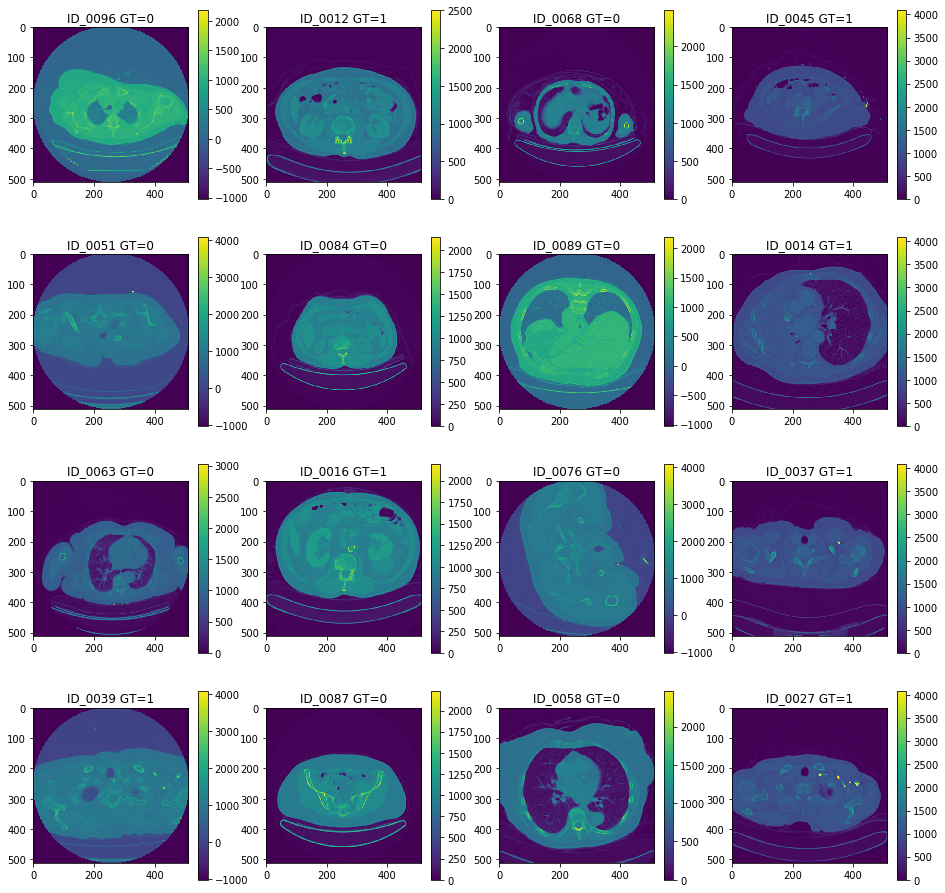

In [6]:
def show_images(cohort):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,16))
    for ix, ax in enumerate(axes.flat):   # Show just a selection
        im = cohort.images[ix]
        gt = cohort.groundtruth[ix]
        pltim = ax.imshow(im)
        ax.set_title("%s GT=%d"% (cohort.ids[ix], gt))
        cbar=fig.colorbar(pltim, ax=ax)
    plt.show()
        
show_images(cohort=Cohort())

## Preprocessing

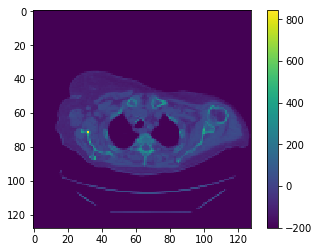

😃 test__preprocess_one_dicom passed.
😃 test_preprocessed_cohort_accessors passed.


In [7]:
class PreprocessedCohort(object):
    """ 
    Represents cohort of data with basic pre-procession applied.  For example, deal with padding,
    conversion to Hounsfield etc.  At this stage we are no longer concerned with file formats, directories
    etc.
    """
    downsample_factor = (4, 4)
    imshape = tuple(512//dsf for dsf in downsample_factor)  # e.g. (128, 128)
    
    def __init__(self, cohort):
        dicoms = cohort.dicoms
        
        self.size = cohort.size   # Number of images
        self.ids = cohort.ids
        self.groundtruth = cohort.groundtruth
        self.dicoms = cohort.dicoms
        
        self._preprocessed_images = None
        
    def _preprocess_one_dicom(self, dcm):
        """ Return a nicely normalised numpy float32 image """
        raw_image = dcm.pixel_array
        padding = dcm.data_element('PixelPaddingValue').value if 'PixelPaddingValue' in dcm else None
        # print(raw_image.dtype)
        slope = dcm.data_element('RescaleSlope').value
        intercept = dcm.data_element('RescaleIntercept').value
        
        image = np.array(raw_image, dtype=np.float32)
        image = image * slope + intercept
        image = np.array(image, dtype=np.float32)
       
        # It seems that padding value lies!  So we'll just clamp image values and hope for the best!
        # print("Image (min,max) = (%6.1f, %6.1f)" % (np.min(image), np.max(image)))
        clip_min = -200.0
        clip_max = 1000.0
        image[image < clip_min] = clip_min
        image[image > clip_max] = clip_max
            
        assert np.min(image) >= clip_min
        assert np.max(image) <= clip_max
        
        # Finally, downscale !
    
        image = downscale_local_mean(image, self.downsample_factor)
            
        return image
        
        
    @property
    def images(self):
        """ Lazily apply normalisation """
        if self._preprocessed_images is None:
            self._preprocessed_images = [self._preprocess_one_dicom(dcm) for dcm in self.dicoms]
        return self._preprocessed_images
    
def test__preprocess_one_dicom():
    cohort = Cohort()
    ppch = PreprocessedCohort(cohort)
    dcm1 = cohort.dicoms[0]
    image = ppch._preprocess_one_dicom(dcm1)
    assert image.shape == PreprocessedCohort.imshape
    plt.imshow(image)
    plt.colorbar()
    plt.show()
    print(SMILY, "test__preprocess_one_dicom passed.")
    
def test_preprocessed_cohort_accessors():
    ppch = PreprocessedCohort(Cohort())
    assert len(ppch.images) == len(ppch.ids) == len(ppch.groundtruth) == ppch.size
    print(SMILY, "test_preprocessed_cohort_accessors passed.")
    
test__preprocess_one_dicom()
test_preprocessed_cohort_accessors()

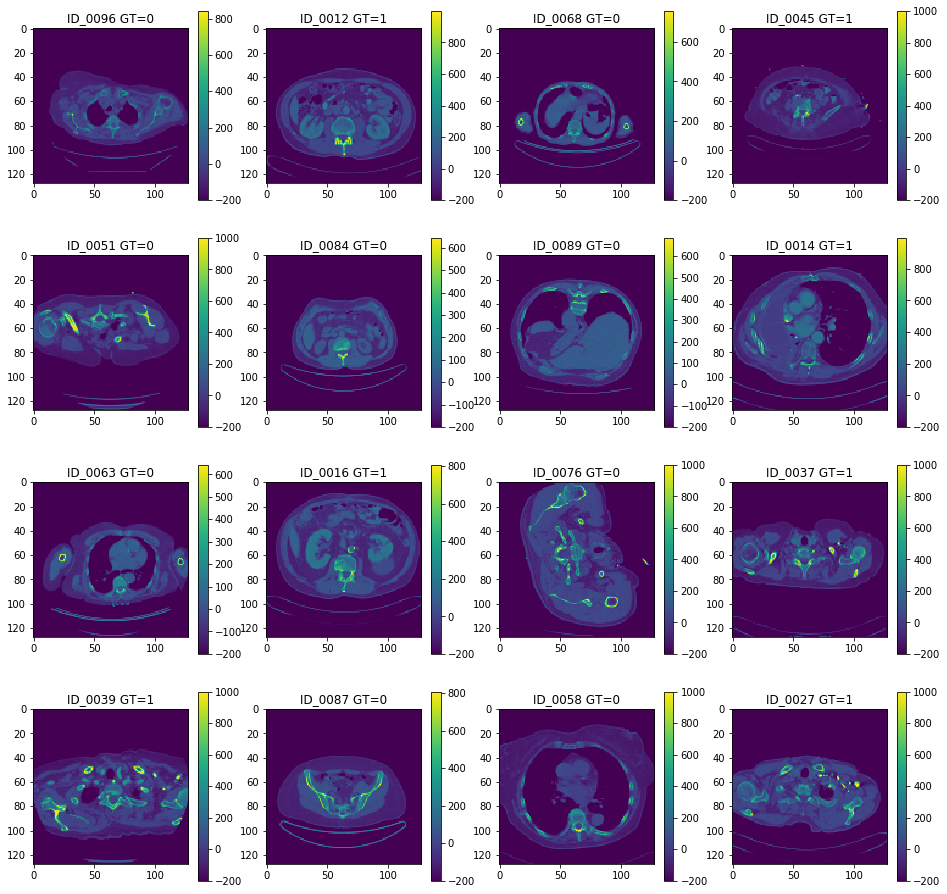

In [8]:
show_images(PreprocessedCohort(Cohort()))

## Dataset train / test split and preparation for learning

In [9]:
def data_scaling(images):
    """
    Given a list of pre-processed images (e.g. from PreprocessedCohort.images) perform
    intensity scaling and reshaping, returning a 4D tensor (n, x, y, 1) ready for feeding to a network
    """
    
    siz = images[0].shape
    x_data = np.array(images).reshape(-1, siz[0], siz[1], 1)
    x_data = x_data.astype(np.float32)
    x_data = (x_data + 100) / 150.0
    mean, sd = np.mean(x_data), np.std(x_data)
    min_, max_ = np.min(x_data), np.max(x_data)
    print("data_scaling: shape:", x_data.shape, "min,max:", (min_, max_), "mean,sd:", (mean, sd))
    
    return x_data

def test_data_scaling():
    xs, ys = 64, 128
    im = np.random.uniform(size=(xs, ys),high=2000, low=-300)
    n = 3
    images = [im] * n  # test set of just 3 images
    x_data = data_scaling(images)
    expected_shape = (n, xs, ys, 1)
    assert x_data.shape == expected_shape
    assert x_data.dtype == np.float32
    
test_data_scaling()

data_scaling: shape: (3, 64, 128, 1) min,max: (-1.329515, 13.999613) mean,sd: (6.310057, 4.438861)


## Convolutional Neural Network Model

In [10]:
def build_model(image_shape):
    input_shape = image_shape + (1,)  # e.g. (128, 128, 1)
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(8, (3, 3), strides=(1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    return model

def test_build_model():
    model = build_model((128, 128))
    model.summary()
    print(SMILY, "test_build_model passed.")

test_build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 8)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                32010     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
__________

In [11]:
import h5py
def save_model(model, fname):
    """ Save model and wieghts to fname and fname.h5 files respectively 
    fname can include a directory which will be created if it doesn't exist"""
    
    directory = os.path.dirname(fname)
    if directory and not os.path.isdir(directory):
        print("Creating directory %s" % directory)
        os.makedirs(directory)
        
    model_json = model.to_json()
    with open(fname+'.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights(fname+'.h5')
    print("Model saved to %s[.json,.h5] files" % fname)

def load_model(fname):
    """ Load a model from fname.json and fname.h5, and return it. 
    (Note that the loaded model must be compiled before use)"""
    # load json and create model
    json_file = open(fname+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(fname + '.h5')
    print("Loaded model from %s[.json,.h5] files" % fname)
    return loaded_model

def test_model_save_and_load():
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=(5, 1)))
    save_model(model, 'gash/test_model')
    model2 = load_model('gash/test_model')
    print(SMILY, "test_model_save_and_load passed.")
    
test_model_save_and_load()

Model saved to gash/test_model[.json,.h5] files
Loaded model from gash/test_model[.json,.h5] files
😃 test_model_save_and_load passed.


In [12]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        
    def plot_training(self):
        epochs = range(1, len(self.acc)+1)
        plt.plot(epochs, self.acc, label='Train')
        plt.plot(epochs, self.val_acc, label='Validation')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()


## Experiment - putting it all together

data_scaling: shape: (100, 128, 128, 1) min,max: (-0.6666667, 7.3333335) mean,sd: (-0.104562804, 0.8816936)
Training set: 41 class 0, 39 class 1
Testing set:  9 class 0, 11 class 1
Train on 64 samples, validate on 16 samples
Epoch 1/20
 - 0s - loss: 0.7283 - acc: 0.5312 - val_loss: 0.6661 - val_acc: 0.6875
Epoch 2/20
 - 0s - loss: 0.6602 - acc: 0.5781 - val_loss: 0.6642 - val_acc: 0.5000
Epoch 3/20
 - 0s - loss: 0.6425 - acc: 0.4844 - val_loss: 0.6532 - val_acc: 0.6875
Epoch 4/20
 - 0s - loss: 0.5995 - acc: 0.8438 - val_loss: 0.6354 - val_acc: 0.5625
Epoch 5/20
 - 0s - loss: 0.5286 - acc: 0.9219 - val_loss: 0.6248 - val_acc: 0.5000
Epoch 6/20
 - 0s - loss: 0.4233 - acc: 0.9375 - val_loss: 0.6149 - val_acc: 0.6250
Epoch 7/20
 - 0s - loss: 0.3815 - acc: 0.8750 - val_loss: 0.6557 - val_acc: 0.6250
Epoch 8/20
 - 0s - loss: 0.2940 - acc: 0.9375 - val_loss: 0.6726 - val_acc: 0.6250
Epoch 9/20
 - 0s - loss: 0.2913 - acc: 0.9062 - val_loss: 0.6427 - val_acc: 0.6250
Epoch 10/20
 - 0s - loss: 0.

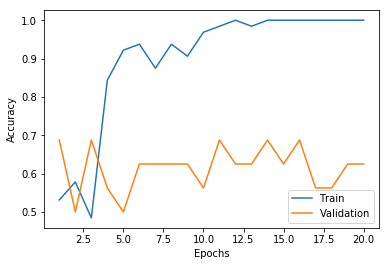

Test accuracy 0.900:


In [13]:
def main():
    ppch = PreprocessedCohort(Cohort())
    x_data = data_scaling(ppch.images)
    y_data = keras.utils.to_categorical(ppch.groundtruth, 2)
    ids = ppch.ids

    x_train, x_test, y_train, y_test, ids_train, ids_test= \
        train_test_split(x_data, y_data, ids, 
                         test_size=0.20, shuffle=True, random_state=21)

    print("Training set: %d class 0, %d class 1" % (np.sum(y_train[:,0]), np.sum(y_train[:,1])))
    print("Testing set:  %d class 0, %d class 1" % (np.sum(y_test[:,0]), np.sum(y_test[:,1])))
    
    input_shape = PreprocessedCohort.imshape
    model = build_model(input_shape)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    history = AccuracyHistory()
    
    model.fit(x_train, y_train,
              batch_size=20,
              shuffle=True,
              epochs=20,
              verbose=2,
              validation_split=0.2,
              callbacks=[history])
    
    save_model(model, 'models/mymodel')
    
    history.plot_training()
    
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy %5.3f:' % score[1])
    
# Lets do it!
main()
    